# Data Science Project - BIU - WeissBeerger

Table of Contents:
1. The Company
2. The Data
3. Our Project’s Goal
4. Data Processing
5. Feature Engineering
6. Models
7. Where we got stuck
8. Insights & Discussions

----

## 1. The Company

### WeissBeerger

WeissBeerger, an Israeli start-up based in Tel-Aviv, develops IoT analytics tools that include sensors in the beer taps, refrigerators and other important points in the supply chain to provide bar and restaurant owners important beverage analytics.
Nowadays they mostly aim to analyze data based on table orders rather than IoT, mostly due to the availability of data.

------

## 2. The Data

The data we received from the company consists of table orders from restaurants all over Canada.  
Because of the massive amount of data (a simple query for a week has supplied us with about 1.75M order items, about 300K tables), we decided to focus on Toronto, which consists of a considerable volume of the data (around 80%).

A single table order consists of a unique `order_id`, along with the item titles and numeric features that come along with the items ordered at the table.

#### Example Table (taken from the initial data we've received):

In [3]:
import pandas as pd

In [4]:
data = pd.read_csv("../data/original_data.csv")

In [24]:
pd.set_option('display.max_columns', 500)

In [25]:
data[data.order_id == 650818052]

,city,bar_id,order_id,order_time,order_item_id,title,category_id,beer_brand_id,beer_serving_type_id,beer_volume,item_qty,sales_before_tax,sales_inc_tax,guest_count,waiter_id,country,country_id,state,state_id,timezone,bar_type_id,status,last_status,is_bulk,bar_type,data_availability_status_id
1574737,Toronto,23193,650818052,2019-07-19 13:08:06.000,65081805204,Pint Coors Light,1.0,280,2,0.591,1.0,5.97,6.746852,0,2011.0,Canada,195,Ontario,49,America/Toronto,1,12,0,0,Bar/Pub,1
1574738,Toronto,23193,650818052,2019-07-19 13:08:06.000,65081805202,Chicken Fingers SAUCE,2.0,0,0,0.000,1.0,1.00,1.130126,0,2011.0,Canada,195,Ontario,49,America/Toronto,1,12,0,0,Bar/Pub,1
1574739,Toronto,23193,650818052,2019-07-19 13:08:06.000,65081805201,Chicken Fingers,2.0,0,0,0.000,1.0,10.00,11.301259,0,2011.0,Canada,195,Ontario,49,America/Toronto,1,12,0,0,Bar/Pub,1
1574740,Toronto,23193,650818052,2019-07-19 13:08:06.000,65081805205,Pop,4.0,0,0,0.000,1.0,2.00,2.260252,0,2011.0,Canada,195,Ontario,49,America/Toronto,1,12,0,0,Bar/Pub,1
1574741,Toronto,23193,650818052,2019-07-19 13:08:06.000,65081805203,+add Gravy,2.0,0,0,0.000,1.0,1.00,1.130126,0,2011.0,Canada,195,Ontario,49,America/Toronto,1,12,0,0,Bar/Pub,1
1574742,Toronto,23193,650818052,2019-07-19 13:08:06.000,65081805200,Chicken Stirfry TERIYAKI,2.0,0,0,0.000,1.0,11.00,12.431385,0,2011.0,Canada,195,Ontario,49,America/Toronto,1,12,0,0,Bar/Pub,1


As can be seen:
- The table open time is at 13pm (`order_time`)
- There are 2 main food items (Chicken Fingers 10\\$ & Chicken Stirfry 11\\$) with sauces
- There are 2 drinks, 1 pint of a Coors Light beer, the other is pop
- Some of you may guess it is a lunch for two (but who knows?)
- Its `guest_count` is 0 (we will dive into this problem later on)

#### Focus

In order to derive more interesting insights, we've picked 3 interesting periods during the past year:
1. Silvester (December 23, '18 - January 5, '19)
2. Valentine (February 10, '19 - February 16, '19)
3. Hockey Season (April 10, '19 - April 24, '19)

In [26]:
silvester = pd.read_csv("../data/toronto_silvester_20181223_20190105.csv")

In [33]:
silvester[silvester.order_id == 360893871]

,bar_id,order_id,order_time,order_time_closed,order_item_time,order_item_id,item_qty,sales_before_tax,sales_inc_tax,guest_count,title,category_id,beer_brand_id,beer_serving_type_id,beer_volume
109,1269,360893871,2018-12-28 19:38:00.000,2018-12-28 20:24:04.000,2018-12-28 19:39:00.000,4476325129,1.0,3.99,4.508357,2,POP.,4.0,0,0,0.0
110,1269,360893871,2018-12-28 19:38:00.000,2018-12-28 20:24:04.000,2018-12-28 19:39:00.000,4476325126,1.0,21.97,24.824210,2,SIRL.FRITES+,2.0,0,0,0.0
111,1269,360893871,2018-12-28 19:38:00.000,2018-12-28 20:24:04.000,2018-12-28 19:38:00.000,4476325125,1.0,14.35,16.214265,2,CALAMARI,2.0,0,0,0.0
112,1269,360893871,2018-12-28 19:38:00.000,2018-12-28 20:24:04.000,2018-12-28 19:39:00.000,4476325128,1.0,2.97,3.355844,2,Add.Rst.Garlic.Mash--,2.0,0,0,0.0
113,1269,360893871,2018-12-28 19:38:00.000,2018-12-28 20:24:04.000,2018-12-28 19:39:00.000,4476325127,1.0,15.99,18.067324,2,CHK.GOATCHS.WRAP,2.0,0,0,0.0


As can be seen:
- The table open time is at 19:38pm (`order_time`)
- The table close time is at 20:24pm (`order_time_closed`)
- All of the order items were ordered together, right when the table opened (or, a minute later) (`order_item_time`)
- There are 2 main food items (Fried Potatoes 22\\$ & Goat Cheese-Stuffed Chicken 16\\$) with roasted garlic mashed potatoes (`title`, `category_id`)
- There is a single large shareable food item (Calamari 14\\$)
- There is a single drink - pop
- Some of you may guess it is a lunch for two (as the `guest_count` suggests)

#### Features present in the tables

In [27]:
silvester.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541499 entries, 0 to 541498
Data columns (total 15 columns):
bar_id                  541499 non-null int64
order_id                541499 non-null int64
order_time              541499 non-null object
order_time_closed       541499 non-null object
order_item_time         541499 non-null object
order_item_id           541499 non-null int64
item_qty                541499 non-null float64
sales_before_tax        541499 non-null float64
sales_inc_tax           541499 non-null float64
guest_count             541499 non-null int64
title                   541499 non-null object
category_id             541422 non-null float64
beer_brand_id           541499 non-null int64
beer_serving_type_id    541499 non-null int64
beer_volume             541497 non-null float64
dtypes: float64(5), int64(6), object(4)
memory usage: 62.0+ MB


- `bar_id`
- `order_id`
- `order_time` - open time for table
- `order_time_closed` - close time for table
- `order_item_time` - order time for a specific item of the table
- `order_item_id`
- `item_qty` - quantity of that exact item in the order
- `sales_before_tax`
- `sales_inc_tax`
- `guest_count` - total number of guests in table
- `title` - name of dish / beverage
- `category_id` - out of 6 possible categories
- `beer_brand_id` - when the item is a beer (otherwise: filled with 0)
- `beer_serving_type` - out of 6 possible categories (bottle, can, glass, keg, jug)
- `beer_volume` - when the item is a beer (otherwise: 0)

**`category_id`**:
1. beer
2. food
3. liquer and alcohol
4. soft drinks
5. side dishes
6. cocktails and wine

These features have outliers which should be handled, also unreliable values.

Examples:
- `guest_count` with value of 0
- `guest_count` that seem weird when looking at the data (lots of food orders when there's only 1 person)
- negative values

----

## 3.  Our Project’s Goal

### Goal:
Be able to predict the type of **Occasion** that appears at a table, given the table order

### Input:
Aggregated table of all item rows (as shown above)

### Output:
Type of **Occasion**

#### What are Occasions?

Through collaborations with the company representatives, we were given initial occasions to work with, and were allowed to change them as we saw fit.

Original Occasions:
	- Male social - occasion socializing with males only
	- Meal Occasion - key activity meal
		○ Possible to divide into a lot
		○ Meal formal
		○ Meal aformal
		○ Hungry / munchies
	- Party - a lively occasion where key activity is party
	- Mix-group social
		○ Date
		○ Happy hour
	- Relax together - doing a relax activity
    - Relax alone!

These are not the occasions that we ended up precisely using, but were a starting point for us.

### Annotations Task

Given these goals, our first step was to create a small annotation task for ourselves, in order to be able to understand the data and the task that's required of us.

### Intuition - Guest Count

We noticed that a major feature for predicting the occasion would have to be the guest count. Usually the number of people that are present at a table, can tell us what type of occasion is happening, or at least give us a hint.

Because of this - let's take a closer look at the feature `guest count`.

### Analyzing the data and annotation guest count

When looking closely at the data, we noticed that a lot of the times the given `guest_count` feature in a given table was not believable.

We decided to annotate multiple tables for `guest_count`, and see if its even a feasible task.

Take a look at the following tables:

In [35]:
data[data["order_id"] == 648222217]

,city,bar_id,order_id,order_time,order_item_id,title,category_id,beer_brand_id,beer_serving_type_id,beer_volume,item_qty,sales_before_tax,sales_inc_tax,guest_count,waiter_id,country,country_id,state,state_id,timezone,bar_type_id,status,last_status,is_bulk,bar_type,data_availability_status_id
156005,Toronto,1177,648222217,2019-07-15 18:26:00.000,64822221700,CORONA BTL,1.0,128,1,0.355,1.0,6.25,7.063457,1,788.0,Canada,195,Ontario,49,America/Toronto,10,11,0,0,Casual Dining,1
156006,Toronto,1177,648222217,2019-07-15 18:26:00.000,64822221706,CORONA BTL,1.0,128,1,0.355,1.0,6.25,7.063457,1,788.0,Canada,195,Ontario,49,America/Toronto,10,11,0,0,Casual Dining,1
156007,Toronto,1177,648222217,2019-07-15 18:26:00.000,64822221705,CORONA BTL,1.0,128,1,0.355,1.0,6.25,7.063457,1,788.0,Canada,195,Ontario,49,America/Toronto,10,11,0,0,Casual Dining,1
156008,Toronto,1177,648222217,2019-07-15 18:26:00.000,64822221707,CORONA BTL,1.0,128,1,0.355,1.0,6.25,7.063457,1,788.0,Canada,195,Ontario,49,America/Toronto,10,11,0,0,Casual Dining,1
156009,Toronto,1177,648222217,2019-07-15 18:26:00.000,64822221708,CORONA BTL,1.0,128,1,0.355,1.0,6.25,7.063457,1,788.0,Canada,195,Ontario,49,America/Toronto,10,11,0,0,Casual Dining,1
156010,Toronto,1177,648222217,2019-07-15 18:26:00.000,64822221704,WINGS.5PC,2.0,0,0,0.000,1.0,10.47,11.832703,1,788.0,Canada,195,Ontario,49,America/Toronto,10,11,0,0,Casual Dining,1
156011,Toronto,1177,648222217,2019-07-15 18:26:00.000,64822221701,CORONA BTL,1.0,128,1,0.355,1.0,6.25,7.063457,1,788.0,Canada,195,Ontario,49,America/Toronto,10,11,0,0,Casual Dining,1
156012,Toronto,1177,648222217,2019-07-15 18:26:00.000,64822221703,WINGS,2.0,0,0,0.000,1.0,0.00,0.000000,1,788.0,Canada,195,Ontario,49,America/Toronto,10,11,0,0,Casual Dining,1
156013,Toronto,1177,648222217,2019-07-15 18:26:00.000,64822221702,Add.Fries^,2.0,0,0,0.000,1.0,2.97,3.356555,1,788.0,Canada,195,Ontario,49,America/Toronto,10,11,0,0,Casual Dining,1


There's an order for wings w/ fries + 6 corona beer bottles.

We can see the feature `guest_count` equals 1, is it though?

How many people are sitting at the table?  
Even between ourselves, our guest count labels ranged from 3 people to 6.

In [21]:
data[data["order_id"] == 649560864]

,city,bar_id,order_id,order_time,order_item_id,title,category_id,beer_brand_id,beer_serving_type_id,beer_volume,item_qty,sales_before_tax,sales_inc_tax,guest_count,waiter_id,country,country_id,state,state_id,timezone,bar_type_id,status,last_status,is_bulk,bar_type,data_availability_status_id
1372306,Toronto,1279,649560864,2019-07-17 16:32:00.000,64956086400,BEACHED,3.0,0,0,0.0,1.0,0.0,0.0,0,65.0,Canada,195,Ontario,49,America/Toronto,10,11,0,0,Casual Dining,1


Or for example this table says the guest count is 0, clearly this is wrong.

Also, the representatives themselves mentioned the `guest_count` feature is not reliable.

    In general, we found it to be a very hard task to predict the guest count, based on the data available to us alone. At the time, we were only allowed to have timestamps of the whole order, and not of each item (i.e. the `order_item_time` was not present).

### Conclusion for the annotation task

After relating to the company the difficulty and necessity of guest count, and the representatives informing us that it is a known and difficult problem that they desperately need to solve, we decided to divide our work into two separate goals. This simply doesnt supply enough signal to correctly annotate the guest count (GC).

### Goal A 
Predict Occasions given **"trustworthy"** data, meaning we assume we have true GC number and based on that we would predict the occasion.  
We will filter out the data that isn't trustworthy to contain only believable bars with "correct guest count".  
We explain further under *Data Processing* what believable bars are.

### Goal B
Implement a guest count model given the above described data as labeled data.


This made our work much easier to handle, and made it so that we focued each task on a closed environment, rather than have a lot of noise in the original data and a vague direction.

**Combining both of the goals above, we had the whole occasions-classifier product: being able to predict the occasions whether or the `guest_count` feature is present / can be trusted.**

-----

## 4. Data Processing

We created the following three processing steps to clean and filter our data, and all of our models and data are assumed to have gone through this process.
1. Quality Bars
2. Data Cleaning
3. Feature Engineering

### 4.1 Quality Bars

Since we wanted to count on the `guest_count` feature in the occasion model, we decided to filter out bars that are untrustworthy, meaning bars that exhibited unusual bahavior.

* We looked at the `guest_count` distribution per bar_id.

We started with more than 700 bars, and eventaully after filtering out bars we ended up with 35 trustworthy bars.
(~30k table orders)

Our filtering choices for removing bars:
    - (rule 1) Max guest count of 1 or 0
    - (rule 2) Any bars with s.t.d (standard deviation) of > 1.5

We chose these rules after looking at the distribution of bars that seemed believable in their reporting, for example the following bar contains a believable distribution:
(Also based on what the company told us, that about 30% of the data contained guest counts of 1)


In [8]:
bars = data[data.bar_id.isin(pd.read_csv("../Feature_Engineering/best_bars_35.csv").bar_id)]

**An Untrustworty Bar**

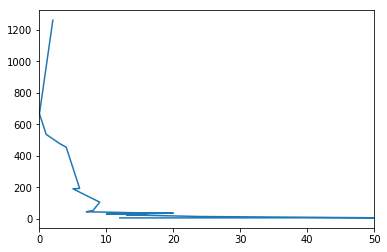

In [28]:
data[data.bar_id == 30058].guest_count.value_counts().plot()

For example the bar above, contains a guest count distribution that is erratic, and doesn't follow the correct distribution that the company relayed to us.

**A trustworthy bar**

Text(0.5, 1.0, 'Guest Count Distribution for a Trustworthy Bar')

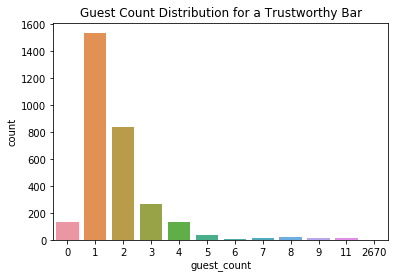

In [38]:
import matplotlib as plt
import seaborn as sns
sns.countplot(x="guest_count", data=data[data.bar_id == 11719]).set_title("Guest Count Distribution for a Trustworthy Bar")

For example the graph above exhibits the behavior or a believable bar, based on what the company representative shared with us they usually see with the data.

**Our chosen "trustworhty bars" total guest count distribution**

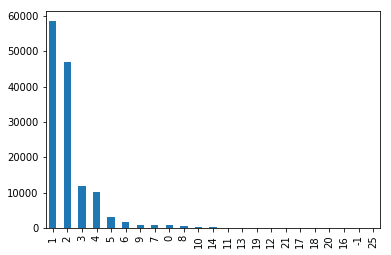

In [13]:
bars.guest_count.value_counts().plot.bar()

### 4.2 Data Cleaning

In data cleaning we removed the follwing two things:
    - (1) Nan tables
    - (2) Titles that were not informative

    (1) is trivial, since we have a lot of data, we removed all tables that contained some Nan values. This occurred for 40k of the tables in only two features, the `category_id` of the item, and the `beer_volume`. We decided to remove them.

    (2) We removed all titles that were not informative for actual meals or drinks, such as sauces, side dishes, cancellations, etc.

Example for some of the textual filtering we did:

In [41]:
def if_keep(title):    
    if "xtra" in title:
        return False
    if "sub" in title and price == 0:
        sub.add(title)
        return False
    elif "add" in title:
        return False
    elif "sauce" in title:
        for t in foods_w_sauce: 
            if t in title: return True
        for t in remove_w_sauce:
            if t in title: return False
        sauces.add(title)
        return False
    elif "no " in title:
        return False
    elif "no." in title:
        return False
    elif "-no " in title:
        return False
    elif "side " in title:
        return False
    
    return True

---

## 5. Feature Engineering

This step proved to be the majority of our work, deciding on important features that eventually we'd want to use, and calculating informative numerical statistics.

The following features were added by us, after (ongoing) careful data evaluation:

- **total_orders_category_id_X** - we sum all the category ids in each item of the total order, and add 6 separate columns for each one, items of 0 cost are not counted (X = 1.0 ... 6.0) [6]
- **total_orders** - total number of items in an order, items of category 5 and items of 0 cost are not counted [1]
- **order_day_of_week** - "Friday", "Monday", etc [1]
- **is_weekend** - is the order day landed on a weekend (friday - sunday) [1]
- **sharable** - is the item "title" a food that is a typical "sharing" food? (pizza, fries, wings, etc) [1]
- **kids_meal** - is the item a "kid" item [1]
- **birthday** - is there a comment in the order about a "birthday" [1]
- **order(_close)_hour/minute** - the order(_close)_time hour & minute for start & close times [4]
- **order_item_hour/minute** - the order_item_time hour & minute [2]
- **period_of_day** - what part of the day did the order occur in (breakfast, lunch, etc) [1]
- **dwell_time** - the total time (in hours) the table order was open for [1]
- **meal_step** - the step in which the current item was ordered in. If the item was ordered after more than 4 minutes than the previous item, then the item is considered to be in the next numeric step. (1 - n steps, in increments of 1) [1]
- **meal_flow_step** - the "flow" step in which the current item was ordered in. The same as meal_step, except the increments are (time between the previous order / 4 minutes) - this means we consider "flow_steps" to be four minutes long. Each flow step is added the total flow steps up to that point [1]
- **total_flow_steps** - the total flow steps in that order [1]
- **meal_flow_last_to_close** - the number of flow steps occurred, between the last item ordered, and till the table order was closed [1]
- **total_meal_steps** - the total number of meal steps in that order [1]
- **first_to_second_order** - the time passed between the 2 first orders [1]
- **avg_time_between_steps** - average time between item orders in that order [1]
- **sit_to_order** - the time passed until the first item order [1]
- **max_items_per_step** - the highest count of items ordered in a step [1]
- **total_large_meals** - number of large meals in that order, items of 0 cost are not counted [1]
- **total_small_meals** - number of small meals in that order, items of 0 cost are not counted [1]
- **total_large_sharable_meals** - number of large sharable meals in that order, items of 0 cost are not counted [1]
- **total_small_sharable_meals** - number of small sharable meals in that order, items of 0 cost are not counted [1]

Most of these features we went on to use in our two models, and especialy they proved crucial for our Occasion model.

---

## 6. Models

### 6.1 Guest Count Model

As mentioned above, we've used the data from the trusted bars as train & test sets.

Before applying a machine learning model to solve the task, the features we saw to be most meaningful were:
- `total_orders_category_id_X`
- `total_orders`
- `max_items_per_step`
- `total(_small/large(_sharable))_meals`

#TODO - This current model is still in the works, and is the final part of our project. This will be updated in the final presentation.

### 6.2 Occasions Heuristics Model

We conclude that since we dont have labeled data regarding the occasions, and after experimenting with a few unsupervised methods, we decided to create a heuristic model to predict the occasion type.  
Since occasion types varies with respect to the GC we decided to split the tables into bins of GC. we split the data GC to four bins:
* GC = 1
* GC = 2
* GC = 3-5
* GC = 6 or more

Each team member looked deeply into a particular bin, the bin owner learned through annotations of orders, what kind of occasions exist in this bin.  
Eventually the bin owner wrote down a set of rules to determine given what kind of event goes on at the table, given a table order . 



#### To maintain intergrity of the model, each bin owner annotated a dev set and a test set. (50 tables dev and 25 test each, resulting in a total of 200 Dev and 100 Test Tables)
#### the heuristic was based on tables from the dev set, and tested on the test set. 
## our average accuracy (on all bins and all occasions) rate reaches 90.5% on Dev, and 82% on Test.

-------------------------------

### 6.2 continued, our final occasions

#### Common Occasions to all bins:
* **BREAKFAST**
* **LUNCH**
* **DINNER**
* **DRINKING**
* **UNKNOWN**

### Occasions per GC Bins

#### Category 1:
*In addition to the common occasions*
1. **MUNCH** - time of day must be `late_night`, contains only meals that are not large
2. **CASUAL DRINK** - any time of day, ratio of food to drinks less than 1.5. up to 3 drinks can have <=1.2 L of beer volume.
3. **NOT_1** - either too many items ordered in a single step, or "kid" in one of the titles.

#### Category 2:
*In addition to the common occasions*
1. **ROMANTIC_DATE**
2. **FANCY_DATE**
3. **MALES_ONLY**
4. **JUST_EATING**
5. **BIRTHDAY**
6. **KIDS**
7. **NOT_2**

#### Category 3-5:
1. **FAMILY EVENT** - orders must contain kids dishes (order item title should be a kid dish)
2. **SOCIAL GATHERING** - any time of day, table must contain shareable dishes and not too many large not sharable dishes
3. **AFTER WORK** - a social gathering occurring after work hours (during the weekdays, around 15-18 pm)


#### Category 6:
##### party events occurs if the guest count is larger than 10
1. **FAMILY EVENT**
3. **SOCIAL GATHERING**
4. **AFTER WORK**



#### The following is our full data distributions on all occasions (running our classifier on the whole data)

In [36]:
hockey_occasions = pd.read_csv("hockey_occasions.csv")
valentine_occasions = pd.read_csv("valentine_occasions.csv")
silvester_occasions = pd.read_csv("silvester_occasions.csv")
occasions = pd.concat([hockey_occasions, valentine_occasions, silvester_occasions], axis=0)
occasions.occasion.value_counts(normalize=True)[:10]


DINNER              0.243324
LUNCH               0.154026
CASUAL_DRINK        0.118580
UNK                 0.114266
DRINKING            0.093926
NOT_1               0.057078
FAMILY_EVENT        0.052430
JUST_EATING         0.048152
FANCY_DATE          0.021998
SOCIAL_GATHERING    0.018557
Name: occasion, dtype: float64

- 24% Dinner
- 15% Lunch

Total of ~40% for meals

- 12% Casual Drink
- 9% Drinking

*We present further interesting insights in section 8*

----

## 7. Where we got stuck

- `guest_count`
- `order_item_time`

One of the main hardships of this project was to understand the scope of the actual given data, and recognize the limitations the data provides.
We ended up realizing Guest count was crucial, but spent a lot of time figuring out how to predict the Guest count given the data we had.

Only after we were able to meet with the representatives from the company, did we get insights that they have into the data and what they do in their own work, as well as access to more features that greatly reduced the complexity of what we wanted to achieve, such as the order_item_time that turned out to be crucial.

Just getting to the point where we realized we need to split the work into two separate goals that seemed more feasible, took quite a lot of time to get to. We believe that clear communication with the company from the beginning, and if they were able to grant us access quicker to all parts of the data we would have saved from work.

All in all the actual work process was an extremely important experience, and understanding how to relate your findings, as well as your direction and the hardships is important for the success of a project.

----


## 8. Insights and Discussions

### there are dozens of data analysis that can be done on this data, we have picked some to share with you that the company people themselves seemed to really appreciate

## Insights into the differences between the bins of guest count - how do different tables look like when the number of people at the table differs

In [40]:
hockey = pd.read_csv("../data/hockey_3_text_processed.csv")
silvester = pd.read_csv("../data/silvester_3_text_processed.csv")
valentine = pd.read_csv("../data/valentine_3_text_processed.csv")
hockey = hockey[~(hockey.guest_count == 0)]
silvester = silvester[~(silvester.guest_count == 0)]
valentine = valentine[~(valentine.guest_count == 0)]
data = pd.concat([hockey, silvester, valentine], axis=0)
dfs = {
    '1'   : data[data.guest_count == 1],
    '2'   : data[data.guest_count == 2],
    '3-5' : data[(data.guest_count >= 3) & (data.guest_count <= 5)],
    '6+'  : data[data.guest_count >= 6]
}

In [44]:
bins = ['1', '2', '3-5', '6+']

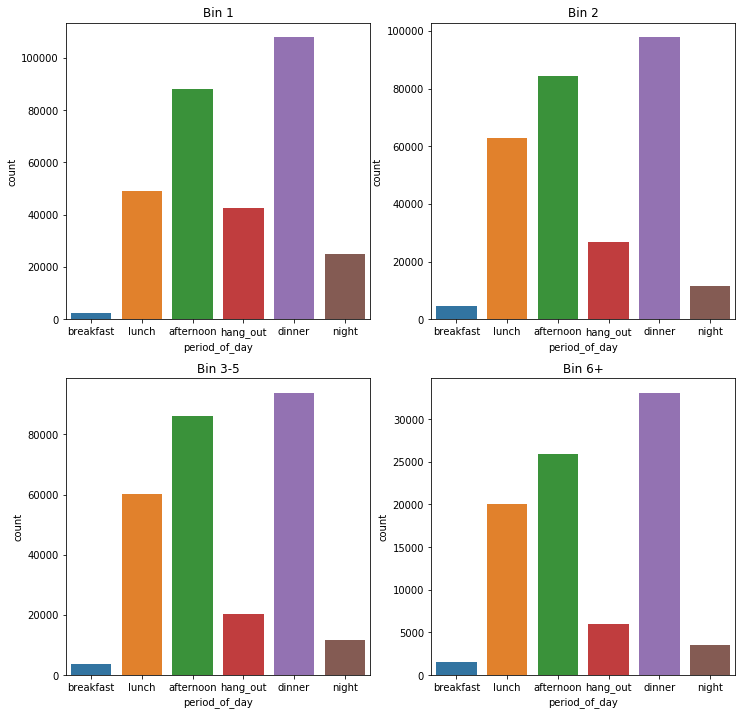

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = [12, 12]

order = ['breakfast', 'lunch', 'afternoon', 'hang_out', 'dinner', 'night']

fig, axes = plt.subplots(2, 2)
axes = axes.flatten()

for i in range(len(bins)):
    bin = bins[i]
    sns.countplot(x='period_of_day', data=dfs[bin], order=order, ax=axes[i])
    axes[i].title.set_text('Bin ' + bin)

#### Notice that bin 1 goes out to eat more around hand_gout and night time than the other bins, while eating out at lunch less than the rest of the bins, also Bin 1 eats out in the afternoons more than the rest.
#### Most of the other bins show similar treands for the other times of the day.

### Days of the week based on the Guest count bins

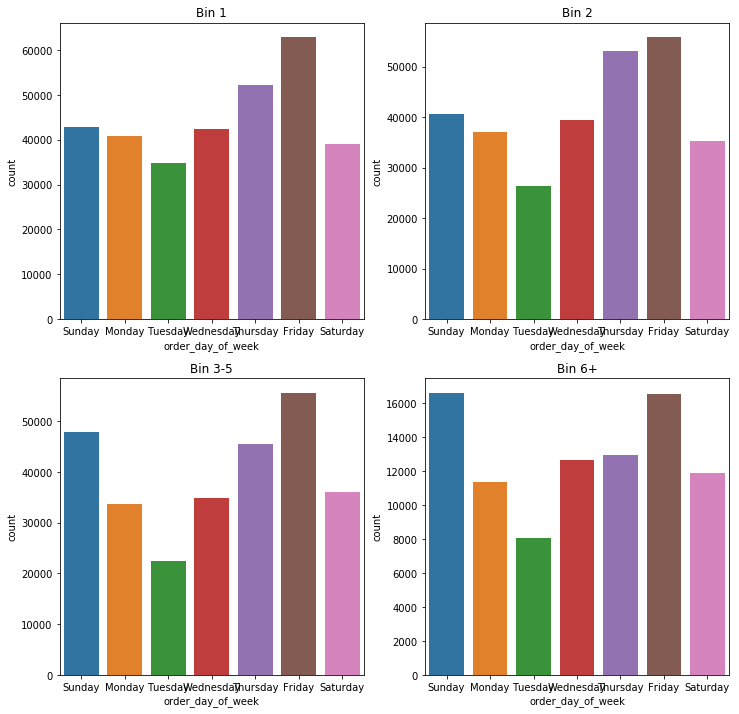

In [48]:
fig, axes = plt.subplots(2, 2)
axes = axes.flatten()
order = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']

for i in range(len(bins)):
    bin = bins[i]
    sns.countplot(x='order_day_of_week', data=dfs[bin], order=order,ax=axes[i])
    axes[i].title.set_text('Bin ' + bin)

### Unsurprisingly, it seems like the big groups hangout more on sundays and fridays, whereas for bings 1 & 2 the more common days are thursdays and fridays.
#### for bin 1 it seems that almost all days other than friday and thursday are pretty evenly spread out.

--------------------------------

## lets look at the differences between our occasions with respect to bins.

### Bin 1

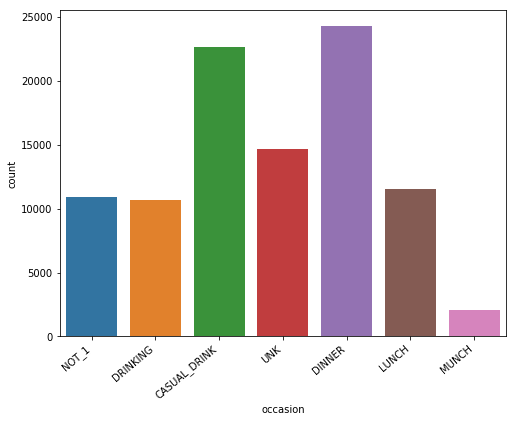

In [50]:
occ_dfs = {
    '1'   : occasions[occasions.guest_count == 1],
    '2'   : occasions[occasions.guest_count == 2],
    '3-5' : occasions[(occasions.guest_count >= 3) & (occasions.guest_count <= 5)],
    '6+'  : occasions[occasions.guest_count >= 6]
}
plt.rcParams['figure.figsize'] = [8, 6]

ax = sns.countplot(x='occasion', data=occ_dfs['1'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.show()

### Bin 2

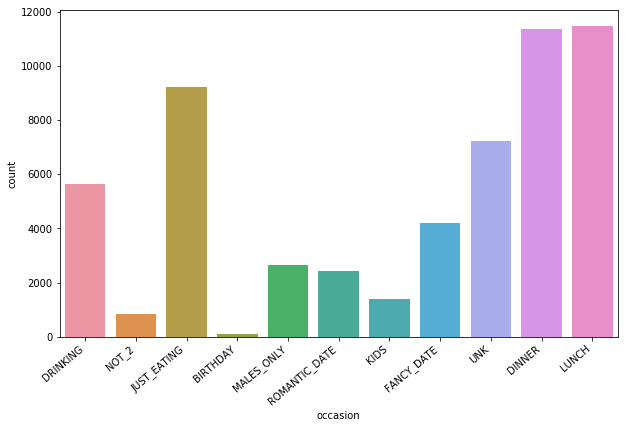

In [52]:
plt.rcParams['figure.figsize'] = [10, 6]

ax = sns.countplot(x='occasion', data=occ_dfs['2'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.show()

### Bin 3-5

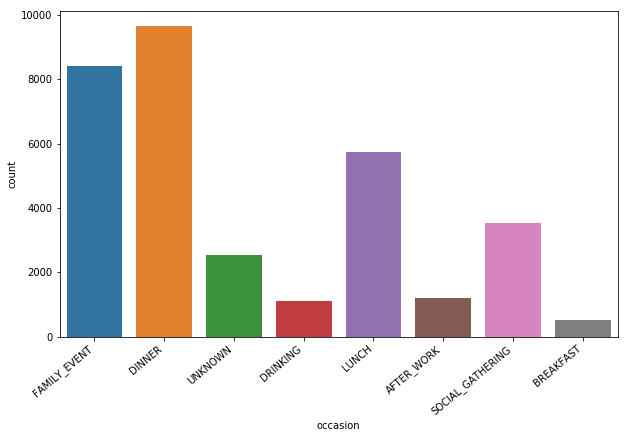

In [53]:
plt.rcParams['figure.figsize'] = [10, 6]

ax = sns.countplot(x='occasion', data=occ_dfs['3-5'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.show()

### Bin 6+

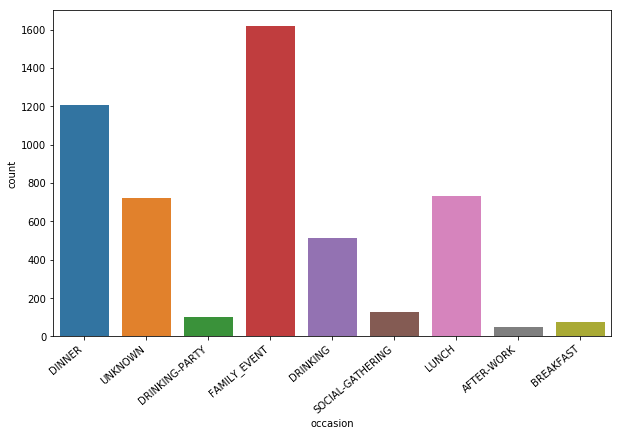

In [54]:
plt.rcParams['figure.figsize'] = [10, 6]

ax = sns.countplot(x='occasion', data=occ_dfs['6+'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.show()

### A lot of these distributions per bins made great sense for the company representatives, and in a way it justified the way we decided on our occasions, and the heuristics we chose to model.

### One surprising thing that the company didn't spend time looking into is the family category, they didn't even know of such occasion, or look for any type of meals with "kids" in them.
### They already informed us that they will use the features they learned of the family event into their models.

In [56]:
family_occ = occasions[occasions.occasion == "FAMILY_EVENT"]
family = data[data.order_id.isin(family_occ.order_id)]

In [57]:
family_dfs = {
    '3-5' : family[(family.guest_count >= 3) & (family.guest_count <= 5)],
    '6+'  : family[family.guest_count >= 6]
}
family.category_id.value_counts(normalize=True)

2.0    0.629776
4.0    0.263367
1.0    0.056607
3.0    0.028624
6.0    0.017918
5.0    0.003708
Name: category_id, dtype: float64

### For example the fact that most family events contain very little alcohol is crucial for them to know.

### Another feature that they were very interested in was the "dwell time", meaning how long do groups stay at the table.


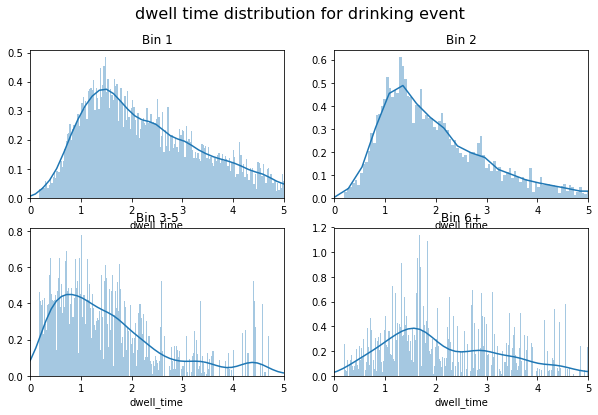

In [59]:
drinking_occ = occasions[occasions.occasion == "DRINKING"]
drinking = data[data.order_id.isin(drinking_occ.order_id)]
drink_dfs = {
    '1'   : drinking[drinking.guest_count == 1],
    '2'   : drinking[drinking.guest_count == 2],
    '3-5' : drinking[(drinking.guest_count >= 3) & (drinking.guest_count <= 5)],
    '6+'  : drinking[drinking.guest_count >= 6]
}
fig, axes = plt.subplots(2, 2)
axes = axes.flatten()
fig.suptitle('dwell time distribution for drinking event', fontsize=16)
for i in range(len(bins)):
    bin = bins[i]
    sns.distplot(drink_dfs[bin]['dwell_time'], bins=500, ax=axes[i])
    axes[i].title.set_text('Bin ' + bin)
    axes[i].set_xlim(0, 5)

### This image was important for the company because it emphasized that large groups distribution tends to spread out longer.

#### we could also see the difference in large groups when looking at family events.

NameError: name 'family_bins' is not defined

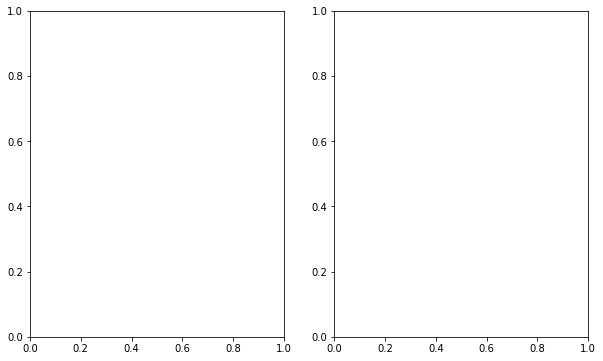

In [63]:

fig, axes = plt.subplots(1, 2)
axes = axes.flatten()
family_dfs = {
    '3-5' : family[(family.guest_count >= 3) & (family.guest_count <= 5)],
    '6+'  : family[family.guest_count >= 6]
}
for i in range(len(family_bins)):
    bin = family_bins[i]
    sns.distplot(family_dfs[bin]['dwell_time'], bins=500, ax=axes[i])
    axes[i].title.set_text('Bin ' + bin)
    axes[i].set_xlim(0, 5)

###### Underneath you may see the dwell time distribution for the drinking event per bin, this is an impressive insight since you can clearly see that the people at the table the more time they spend at the bar

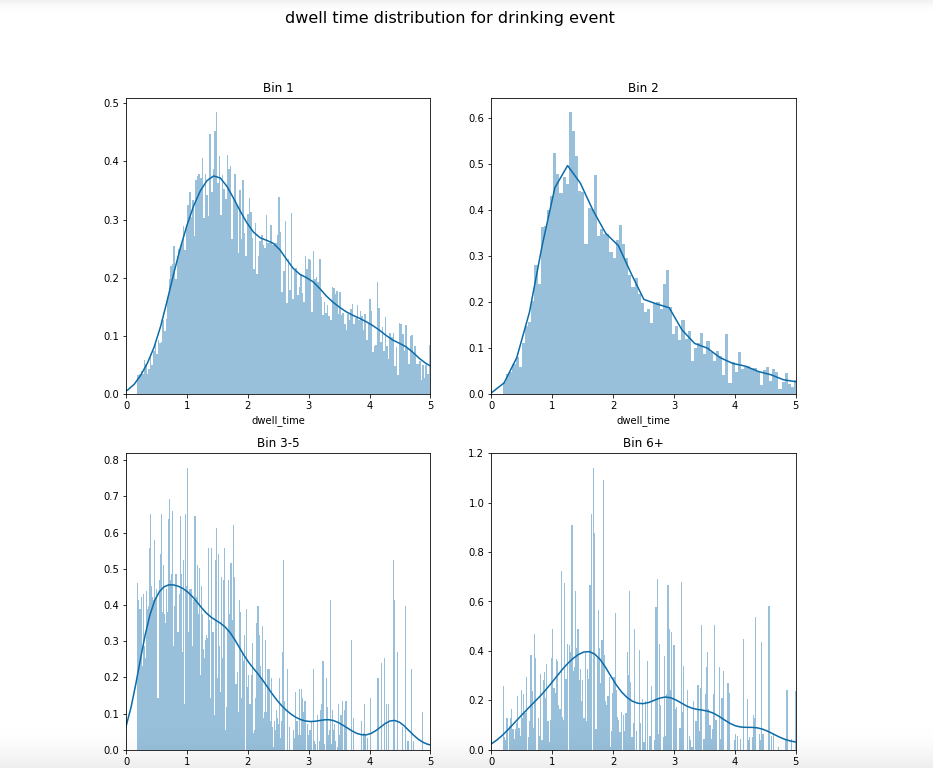

In [16]:
from IPython.display import Image
Image("image1.png")